In [1]:
import pandas as pd
import numpy as np
from glob import glob
import requests
import json

In [2]:
def parse_CL(site):
    df = pd.concat([pd.read_csv(file) for file in glob(f'Ceilometer/*{site}.csv')])

    # replace -999 to NaN
    df = df.replace(-999, np.nan)

    # parse date string
    df['# Time'] = pd.to_datetime(df['# Time'], format='%d/%m/%Y %H:%M:%S')
    
    # interpolate bl_height by time
    df['revised_bl_height'] = df.set_index('# Time')['bl_height'].interpolate(method='time').values

    # aggregate bl_height by hourly average
    df = df.groupby([
        df['# Time'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['# Time'].dt.hour.rename('Hour')
    ])['revised_bl_height'].mean().reset_index(name='CL_BLH').set_index(['Date', 'Hour'])

    return df

In [3]:
def parse_CTM(site, time_offset=10):
    # Careful! The seperator is not ',' but ', ' (space)
    df = pd.concat([pd.read_csv(file, sep=r'\s*,\s*', engine='python') for file in glob(f'CTM_ModelOutput/*{site}.csv')])

    # parse date string
    from datetime import timedelta
    df['Time'] = pd.to_datetime(df[['date', 'time']].astype(str).apply('-'.join, 1), format='%Y%m%d-%H') + timedelta(hours=time_offset)

    df = df.groupby([
        df['Time'].dt.strftime('%Y-%m-%d').rename('Date'), 
        df['Time'].dt.hour.rename('Hour')
    ])['mixing_height'].mean().reset_index(name='CTM_BLH').set_index(['Date', 'Hour'])

    return df

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

def join_CL_CTM(site):
    CLdf = parse_CL(site)
    CTMdf = parse_CTM(site)
    return CLdf.join(CTMdf, how='inner')

def bl_plot(site):
    join_df = join_CL_CTM(site).reset_index()
    join_df['Time'] = pd.to_datetime(join_df[['Date', 'Hour']].astype(str).apply('-'.join, 1), format='%Y-%m-%d-%H')
    join_df.plot(x='Time', y=['CTM_BLH', 'CL_BLH'], title=site)
    plt.show()

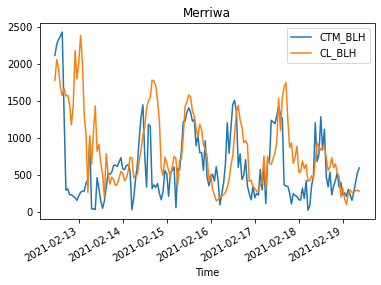

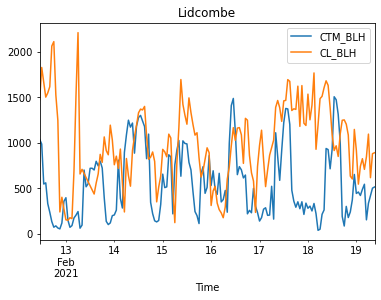

In [5]:
bl_plot('Merriwa')
bl_plot('Lidcombe')

In [6]:
class AQMS_API:
    def __init__(self):
        self.url_prefix = 'https://data.airquality.nsw.gov.au/api/Data/'
        self.headers = {
            'content-type': 'application/json',
            'accept': 'application/json',
        }
        
        self.site_url = 'get_SiteDetails'
        self.parameter_url = 'get_ParameterDetails'
        self.observation_url = 'get_Observations'
        
    def get_data(self, url_suffix, http_method=requests.get, data=None):
        query = self.url_prefix + url_suffix
        response = http_method(url=query, headers=self.headers, json=data)
        return response.json()
    
    def get_sites(self):
        return self.get_data(self.site_url)
    
    def get_parameters(self):
        return self.get_data(self.parameter_url)
    
    def get_observations(self, data=None):
        return self.get_data(self.observation_url, requests.post, data)

# historical observation query builder
def obs_builder(parameter=None, sites=None, start=None, end=None, category=None, sub_category=None, freq=None):
    '''
    start & end : '%Y-%m-%d' format date string
    '''
    def list_parser(s):
        if s is None or isinstance(s, list):
            return s
        else:
            return [s]

    return {
        'Parameters': list_parser(parameter),
        'Sites': list_parser(sites),
        'StartDate': start,
        'EndDate': end,
        'Categories': list_parser(category),
        'SubCategories': list_parser(sub_category),
        'Frequency': list_parser(freq),
    }

In [7]:
api = AQMS_API()

# site id
sites = {
    'Merriwa': 329,
    'Lidcombe': 1141,
}

In [8]:
df = pd.DataFrame.from_records(api.get_parameters())
params = df.loc[
    (df['Category'] == 'Averages') & 
    (df['SubCategory'] == 'Hourly') & 
    (df['Frequency'] == 'Hourly average')
]
params

,ParameterCode,ParameterDescription,Units,UnitsDescription,Category,SubCategory,Frequency
20,CO,Carbon monoxide,ppm,parts per million,Averages,Hourly,Hourly average
25,HUMID,Humidity,%,percent,Averages,Hourly,Hourly average
28,NEPH,Nephelometer,10^-4 m^-1,10^-4 m^-1,Averages,Hourly,Hourly average
40,NH3,Ammonia,pphm,parts per hundred million,Averages,Hourly,Hourly average
47,NO,Nitric Oxide,pphm,parts per hundred million,Averages,Hourly,Hourly average
59,NO2,Nitrogen Dioxide,pphm,parts per hundred million,Averages,Hourly,Hourly average
83,OZONE,Ozone,pphm,parts per hundred million,Averages,Hourly,Hourly average
93,PM10,PM10,µg/m³,microgram per cubic meter,Averages,Hourly,Hourly average
103,PM10d,Particulate Matter (<10 µm) (Dustwatch),µg/m³,microgram per cubic meter,Averages,Hourly,Hourly average
109,PM2.5,PM2.5,µg/m³,microgram per cubic meter,Averages,Hourly,Hourly average


In [9]:
def bl_external(site, site_id):
    query = obs_builder(
        params['ParameterCode'].tolist(), 
        site_id, 
        '2021-02-12',
        '2021-02-19',
        'Averages', 
        'Hourly', 
        'Hourly average'
    )
    obs = pd.DataFrame.from_records(api.get_observations(query))
    obs['Hour'] = obs['Hour'] - 1
    obs['Parameter'] = pd.json_normalize(obs['Parameter'])['ParameterDescription']
    obs = pd.pivot(obs, index=['Date', 'Hour'], columns='Parameter', values='Value').reset_index()
    df = join_CL_CTM(site).join(obs.set_index(['Date', 'Hour']), how='inner').reset_index()
    return df

In [10]:
df = bl_external('Merriwa', 329)
df

,Date,Hour,CL_BLH,CTM_BLH,Carbon monoxide,Humidity,Nephelometer,Nitric Oxide,Nitrogen Dioxide,Ozone,PM10,PM2.5,Rainfall,Sulphur Dioxide,Temperature,Wind Direction (10m),Wind Direction Sigma Theta,Wind Speed (10m)
0,2021-02-12,11,1782.971698,2116.5154,-0.013024,47.927,0.042,-0.023461,0.069158,2.544080,23.290,1.629,0.0,0.012478,26.696,331.472,14.912,7.140
1,2021-02-12,12,2060.904255,2268.4509,-0.003834,46.820,0.051,-0.015987,0.076345,2.843780,18.506,7.472,0.0,0.009091,27.329,341.235,15.817,5.896
2,2021-02-12,13,1942.894737,2332.6211,-0.004704,45.996,0.058,-0.011745,0.066663,3.053180,22.723,6.195,0.0,0.016463,28.087,345.758,13.917,6.096
3,2021-02-12,14,1684.731183,2376.4629,-0.003592,44.181,0.060,-0.026188,0.057879,3.265180,19.386,2.025,0.0,0.031706,28.844,333.913,13.932,6.070
4,2021-02-12,15,1573.967391,2432.8503,-0.002880,43.716,0.065,-0.021037,0.052190,3.347480,19.332,-4.037,0.0,0.039776,29.141,339.577,17.870,5.807
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
161,2021-02-19,5,264.802803,156.5146,-0.033830,91.658,0.102,-0.022306,0.170322,1.083695,12.816,1.575,0.0,0.102550,17.554,129.513,10.023,2.405
162,2021-02-19,6,271.336676,271.2063,-0.035252,91.979,0.105,-0.011042,0.139426,1.114095,9.865,2.849,0.0,0.076057,17.778,130.756,9.991,2.853
163,2021-02-19,7,283.446311,402.5884,-0.032138,92.351,0.099,0.039190,0.266695,1.040695,10.615,2.504,0.0,0.160537,18.322,109.467,27.944,3.619
164,2021-02-19,8,295.176486,530.2465,-0.027304,92.986,0.131,0.079679,0.325995,0.962895,12.016,1.007,1.6,0.100951,18.662,117.478,10.160,4.088


In [11]:
data = {site: bl_external(site, id) for site, id in sites.items()}

In [12]:
def get_df(site):
    if site == 'all':
        df = pd.concat(data.values()).drop(columns='Solar radiation')
    else:
        df = data[site]
    return df.dropna().set_index(['Date', 'Hour'])

def corr(site, method='pearson'):
    return get_df(site).corr(method=method)

from scipy.stats import pearsonr

def p_value(site):
    df = get_df(site)._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 6)
    return pvalues

In [13]:
corr('all', 'pearson').iloc[:, :2]

,CL_BLH,CTM_BLH
CL_BLH,1.000000,0.287952
CTM_BLH,0.287952,1.000000
Carbon monoxide,0.092702,-0.184646
Humidity,-0.667230,-0.518442
Nephelometer,0.006918,-0.173402
Nitric Oxide,0.144480,-0.125607
Nitrogen Dioxide,0.011283,-0.424918
Ozone,0.468203,0.455442
PM10,0.352813,-0.023971
PM2.5,0.017452,-0.217491


In [14]:
p_value('all').iloc[:, :2]

,CL_BLH,CTM_BLH
CL_BLH,0.0,0.000001
CTM_BLH,0.000001,0.0
Carbon monoxide,0.125132,0.002108
Humidity,0.0,0.0
Nephelometer,0.909081,0.003923
Nitric Oxide,0.016502,0.037367
Nitrogen Dioxide,0.852237,0.0
Ozone,0.0,0.0
PM10,0.0,0.692281
PM2.5,0.773255,0.000279


In [15]:
# available method [‘pearson’, ‘kendall’, ‘spearman’]
corr('Lidcombe', 'pearson').iloc[:, :2]

,CL_BLH,CTM_BLH
CL_BLH,1.000000,0.136481
CTM_BLH,0.136481,1.000000
Carbon monoxide,-0.284860,-0.460941
Humidity,-0.576953,-0.437755
Nephelometer,-0.313251,-0.311381
Nitric Oxide,0.152507,-0.249707
Nitrogen Dioxide,-0.013995,-0.600630
Ozone,0.328640,0.399086
PM10,0.138696,-0.119004
PM2.5,-0.148077,-0.148062


In [16]:
p_value('Lidcombe').iloc[:, :2]

,CL_BLH,CTM_BLH
CL_BLH,0.0,0.140567
CTM_BLH,0.140567,0.0
Carbon monoxide,0.001769,0.0
Humidity,0.0,0.000001
Nephelometer,0.000553,0.000599
Nitric Oxide,0.099213,0.006392
Nitrogen Dioxide,0.880438,0.0
Ozone,0.00028,0.000008
PM10,0.134177,0.19931
PM2.5,0.109546,0.109581


In [17]:
corr('Merriwa', 'pearson').iloc[:, :2]

,CL_BLH,CTM_BLH
CL_BLH,1.000000,0.395865
CTM_BLH,0.395865,1.000000
Carbon monoxide,0.522859,0.200391
Humidity,-0.755757,-0.597379
Nephelometer,-0.128754,-0.089435
Nitric Oxide,0.052930,0.150851
Nitrogen Dioxide,-0.104132,-0.312676
Ozone,0.695825,0.497777
PM10,0.475645,0.091247
PM2.5,0.078824,-0.245054


In [18]:
p_value('Merriwa').iloc[:, :2]

,CL_BLH,CTM_BLH
CL_BLH,0.0,0.0
CTM_BLH,0.0,0.0
Carbon monoxide,0.0,0.011856
Humidity,0.0,0.0
Nephelometer,0.108036,0.265323
Nitric Oxide,0.510299,0.059313
Nitrogen Dioxide,0.194331,0.000067
Ozone,0.0,0.0
PM10,0.0,0.255725
PM2.5,0.326444,0.00198
